In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = os.path.join(ROOT_DIR, 'data/processed')
sys.path.append(ROOT_DIR)  # To find local version of the library
# LABELS_DIR = os.path.join(ROOT_DIR, 'data/interim')


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# import cv2
# from IPython.display import display
import skimage
from skimage.draw import polygon
import json 

tf.compat.v1.disable_eager_execution()


In [2]:
from models.maskrcnn.mrcnn import visualize
from models.maskrcnn.mrcnn import model
# from models.maskrcnn.mrcnn import log
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import model as modellib, utils

from src.data import helper

In [15]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [18]:
class CustomConfig(Config):
  NAME = 'sidewalks'
  GPU_COUNT = 1

  # 12GB GPU can typical handle 2 images (1024 x 1024)
  # ColabPro High Ram has roughly 27GB GPU
  IMAGES_PER_GPU = 4

  # Background + 1 sidewalk class 
  NUM_CLASSES = 1 + 10

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 10

  # Number of validation steps to runa tt eh end of 
  # every epoch,larger number improves better accuracy
  # but slows down training
  VALIDATION_STEPS = 50

  # ROIs belwo this threshold are skipped
  DETECTION_MIN_CONFIDENCE = .7   
  DETECTION_NMS_THRESHOLD = 0.3
  LEARNING_RATE =0.0005
  BACKBONE = 'resnet101'
  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 256
  
class CustomDataset(utils.Dataset):
  def load_dataset(self,dataset_dir,subset):
    # self.image_info = {}
    # self.class_info = {}
    # self.data_directory = dataset_dir

    classes = pd.read_csv(os.path.join(dataset_dir,'classes.csv'))
    classes = classes.set_index('CLASS_ID').T.to_dict('list')
    classes = dict([(k,classes[k][0]) for k,v in classes.items()])

    labels = pd.read_csv(os.path.join(dataset_dir, 'labels.csv'), index_col=None)
    labels = labels.set_index('ID').T.to_dict('list')
    for id in labels:
      labs = labels[id][0]
      labels[id] =  np.array([int(i) for i in labs.split(' ')[:-1]])
    

    for class_id,class_name in classes.items():
      self.add_class(source='cityscape',
                   class_id = class_id,
                   class_name = class_name)
      
    # self.class_names = [d['name'] for d in self.class_info.values()]
    
    # iterating to get the image ids
    if subset == 'validation':
      subset = 'val'

    SUBSET_IDs = pd.read_csv(os.path.join(dataset_dir, subset+'.csv'), index_col=0) 
    SUBSET_IDs = [i.split('.')[0] for i in SUBSET_IDs['0'].tolist()]

    for ID in SUBSET_IDs:
    # for i in range(len(data)):
      img_path = os.path.join(dataset_dir, f'images/{ID}.png')
      img_labels = labels[ID]
      self.add_image(source='cityscape',
                     image_id = ID,
                     path = img_path,
                     labels = img_labels)
      
  def load_mask(self,id):
    # if not isinstance(id, str):
    #   id = self.image_info[id]

    img_info = self.image_info[id]
    img_name = img_info['id']
    mask_path = os.path.join(os.path.dirname(os.path.dirname(img_info['path']))
                        ,'segmentations',f'{img_name}.json')

    masks = helper.create_mask(mask_path, img_info['labels'], resize=(256,512))
    return masks, img_info['labels']
  
  def image_reference(self, id):
    info = self.image_info[id]
    if info["source"] == "cityscape":
        return info["id"]
    else:
        super(self.__class__, self).image_reference(id)


In [19]:
config = CustomConfig()

dataset = CustomDataset()
dataset.load_dataset(DATA_DIR,'train')
dataset.prepare()

val_set = CustomDataset()
val_set.load_dataset(DATA_DIR,'val')
val_set.prepare()


In [ ]:
id = 0
img = dataset.load_image(id)
masks,labels = dataset.load_mask(id)
names = dataset.class_from_source_map

visualize.display_top_masks(img,
                            masks,
                            labels,
                            names,
                            limit=8)

In [21]:
tf.keras.backend.clear_session()
temp_log = os.path.join(ROOT_DIR,'data/external')
model = modellib.MaskRCNN(mode='training',config=config, model_dir=temp_log)
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

In [22]:
model.train(dataset, val_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.0005

Checkpoint Path: /Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/external/sidewalks20230507T1443/mask_rcnn_sidewalks_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrc

2023-05-07 14:43:50.951869: W tensorflow/c/c_api.cc:300] Operation '{name:'rpn_class_raw/bias/Assign' id:5693 op device:{requested: '', assigned: ''} def:{{{node rpn_class_raw/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](rpn_class_raw/bias, rpn_class_raw/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-07 14:43:52.748685: W tensorflow/c/c_api.cc:300] Operation '{name:'range' id:11827 op device:{requested: '', assigned: ''} def:{{{node range}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range/start, Rank, range/delta)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

: 

: 

In [39]:
import keras.engine.training_v1 as t
import keras.engine.training_utils_v1 as t_u
import keras.backend as backend

# debuging ValueError: Error when checking input: 
# expected input_image_meta to have shape (15,) 
# but got array with shape (13,)

model_inputs = t_u.ModelInputs(dataset)
inputs = model_inputs.get_symbolic_inputs(return_single_as_list=True)
input_names = model_inputs.get_input_names()


f_inputs = []
f_input_names = []
f_input_shapes = []

for k, v in model_inputs.as_dict():
    print(k,v)
    
    f_input_names.append(k)
    f_inputs.append(v)
    f_input_shapes.append(backend.int_shape(v))

    


input_1 <__main__.CustomDataset object at 0x30e84bee0>


AttributeError: 'CustomDataset' object has no attribute 'shape'

In [34]:
model_inputs.as_dict()

<generator object ModelInputs.as_dict at 0x16c48d4a0>

# Inference

In [8]:
model_path = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')

class InferenceConfig(CustomConfig):
  GPU_COUNT =1 
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = .5

inference_config = InferenceConfig()
temp_log = os.path.join(ROOT_DIR,'data/external')

tf.keras.backend.clear_session()
model = modellib.MaskRCNN(mode = 'inference',
                          config = inference_config,
                          model_dir=temp_log)
model.load_weights(model_path, by_name=True, 
                   exclude=['mrcnn_class_logits','mrcnn_bbox_fc','mrcnn_bbox','mrcnn_mask'])

Instructions for updating:
Use fn_output_signature instead
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-05-02 19:53:30.258969: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

Processing 1 images
image                    shape: (1024, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


/Users/csea/miniconda/envs/tf/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-02 19:53:31.710994: W tensorflow/c/c_api.cc:300] Operation '{name:'bn4s_branch2b/moving_variance/Assign' id:4183 op device:{requested: '', assigned: ''} def:{{{node bn4s_branch2b/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn4s_branch2b/moving_variance, bn4s_branch2b/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-05-02 19:53:33.728895: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost(

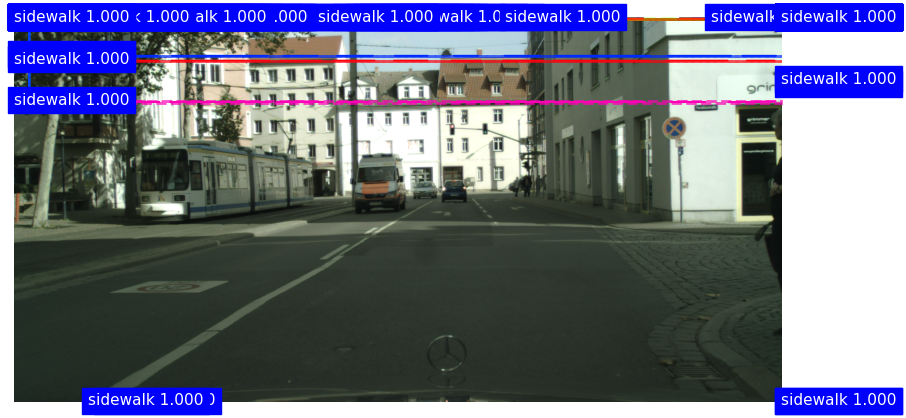

In [9]:
results = model.detect([dataset.load_image('jena_000048_000019')],verbose=1)

# display preferences
def get_ax(rows=1, cols=1, size=10):
  _,ax = plt.subplots(rows,cols,figsize=(size*cols,size*rows))
  return ax

r = results[0]
visualize.display_instances(dataset.load_image('jena_000048_000019'), r['rois'], r['masks'], r['class_ids'], 
                            ['BG','sidewalk'], r['scores'], ax=get_ax(), )

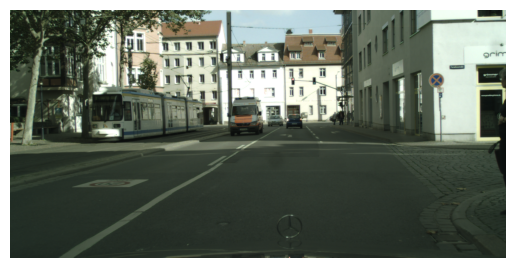

In [10]:
plt.axis('off')
plt.imshow(dataset.load_image('jena_000048_000019'))

sidewalk
sidewalk
sidewalk
sidewalk
sidewalk


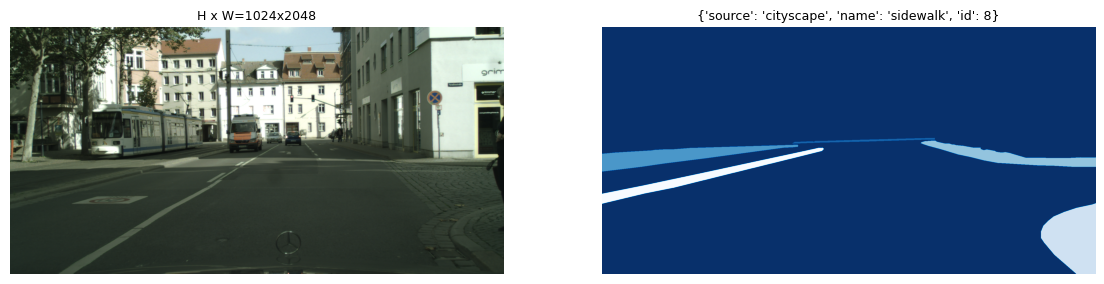

In [14]:
a,b = dataset.load_mask('jena_000048_000019')
c = dataset.load_image('jena_000048_000019')

visualize.display_top_masks(c,a,b,dataset.class_info,limit=1)

In [15]:
dataset.class_names

['sidewalk']

(5, 4)


IndexError: list index out of range

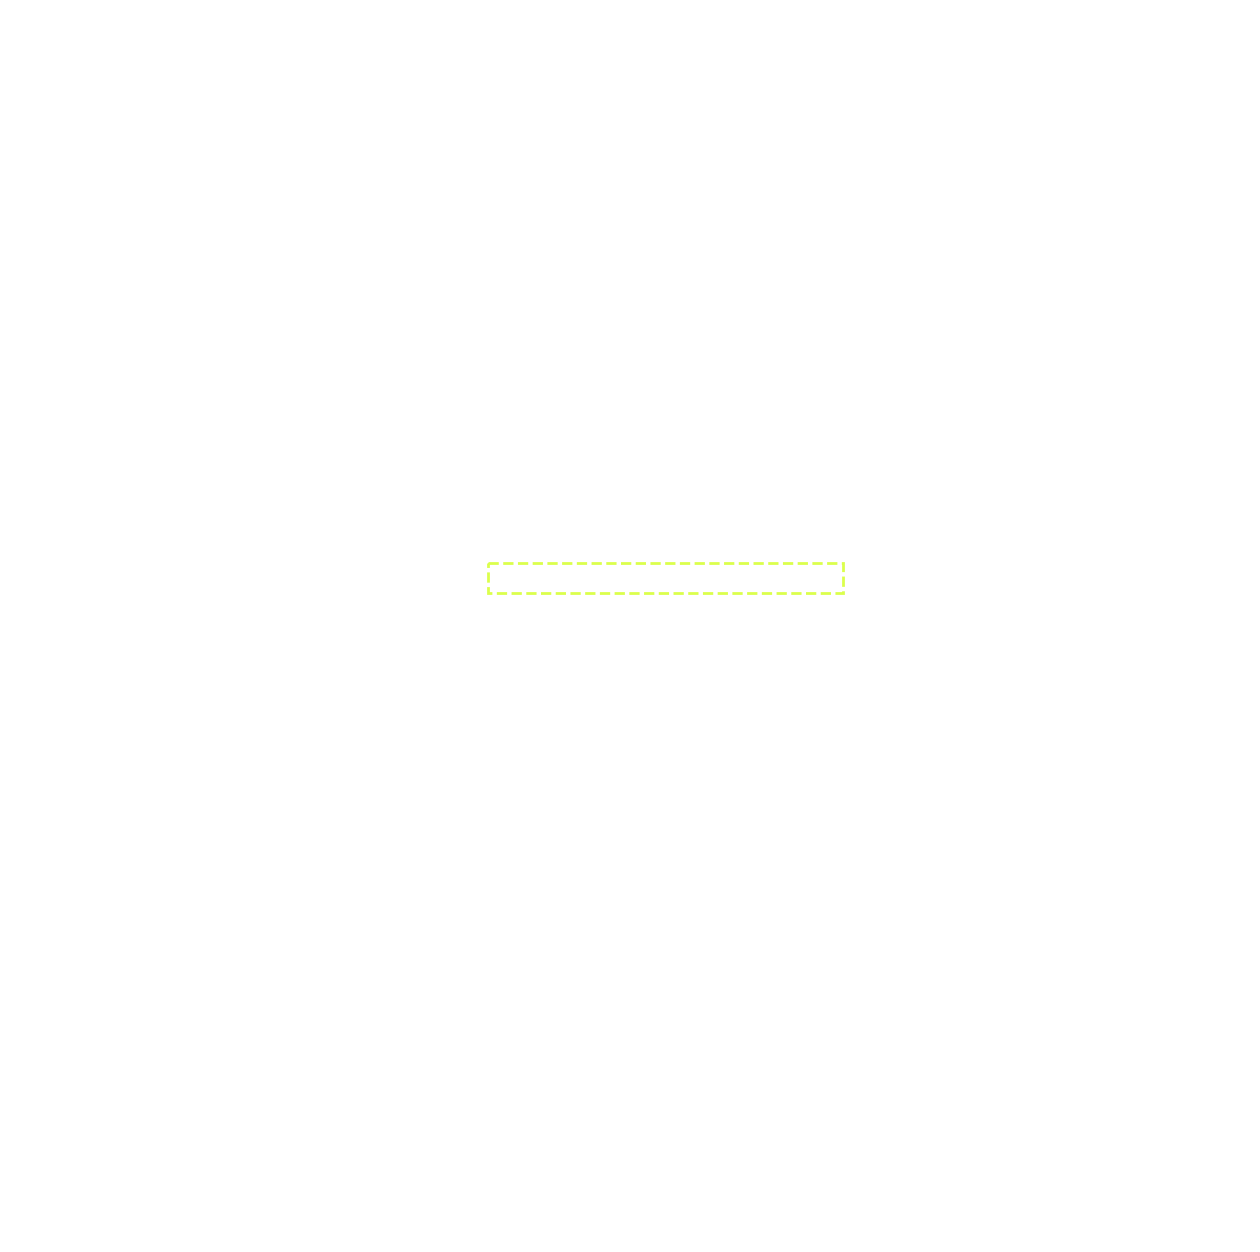

In [16]:
bb = utils.extract_bboxes(a)
print(bb.shape)
visualize.display_instances(c, bb, a, np.array(b), dataset.class_names)

# TF1 -> TF2


In [ ]:
import keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import keras.engine as KE
import tensorflow.keras.models as KM

## norm_boxes_graph


## Model

In [ ]:
input_image = KL.Input(shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                            name="input_image_meta")

# RPN GT
input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

# Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
input_gt_class_ids = KL.Input(
                            shape=[None], name="input_gt_class_ids", dtype=tf.int32)
# 2. GT Boxes in pixels (zero padded)
# [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
input_gt_boxes = KL.Input(
                            shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)

In [ ]:
def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [..., (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels

    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.

    Returns:
        [..., (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    print(h,w)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)

In [ ]:
KL.Lambda(lambda x: norm_boxes_graph(
                x,K.shape(input_image)[1:3]))(input_gt_boxes)

# Load test/trials pls ignore

In [ ]:
import tensorflow.compat.v1 as tf


In [ ]:
sample_mask, _ = dataset.load_mask(0)
plt.imshow(sample_mask)

In [ ]:
dataset.image_info[0]

In [ ]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

In [ ]:
bbox = extract_bboxes(sample_mask)

In [ ]:
np.unique(x)

In [ ]:
plt.imshow(x==8)

In [ ]:
x = skimage.io.imread('/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/interim/ZIP.gtFine_trainvaltest.zip/gtFine/train/zurich/zurich_000069_000019_gtFine_instanceIds.png')
plt.imshow(x)

In [ ]:
plt.imshow(x==8)

In [ ]:
extract_bboxes(x==8)

In [ ]:
image.png

# Debug

MaskRCNN() -> build() -> DetectionTargetLayer() Stuck here

In [ ]:
config = CustomConfig()
config.display()

dataset = CustomDataset()
dataset.load_dataset(DATA_DIR,'train')
dataset.prepare()

val_set = CustomDataset()
val_set.load_dataset(DATA_DIR,'val')
val_set.prepare()

In [ ]:
temp_log = os.path.join(ROOT_DIR,'data/external')
# model = modellib.MaskRCNN(mode='training',config=config, model_dir=temp_log)

mode = 'training'

## Detection Layer



In [ ]:
def detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):
    """Generates detection targets for one image. Subsamples proposals and
    generates target class IDs, bounding box deltas, and masks for each.

    Inputs:
    proposals: [POST_NMS_ROIS_TRAINING, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [MAX_GT_INSTANCES] int class IDs
    gt_boxes: [MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized coordinates.
    gt_masks: [height, width, MAX_GT_INSTANCES] of boolean type.

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized coordinates
    class_ids: [TRAIN_ROIS_PER_IMAGE]. Integer class IDs. Zero padded.
    deltas: [TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw))]
    masks: [TRAIN_ROIS_PER_IMAGE, height, width]. Masks cropped to bbox
           boundaries and resized to neural network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """
    # Assertions
    asserts = [
        tf.Assert(tf.greater(tf.shape(input=proposals)[0], 0), [proposals],
                  name="roi_assertion"),
    ]
    with tf.control_dependencies(asserts):
        proposals = tf.identity(proposals)

    # Remove zero padding
    proposals, _ = modellib.trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = modellib.trim_zeros_graph(gt_boxes, name="trim_gt_boxes")
    gt_class_ids = tf.boolean_mask(tensor=gt_class_ids, mask=non_zeros,
                                   name="trim_gt_class_ids")
    gt_masks = tf.gather(gt_masks, tf.compat.v1.where(non_zeros)[:, 0], axis=2,
                         name="trim_gt_masks")

    # Handle COCO crowds
    # A crowd box in COCO is a bounding box around several instances. Exclude
    # them from training. A crowd box is given a negative class ID.
    crowd_ix = tf.compat.v1.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix = tf.compat.v1.where(gt_class_ids > 0)[:, 0]
    crowd_boxes = tf.gather(gt_boxes, crowd_ix)
    gt_class_ids = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks = tf.gather(gt_masks, non_crowd_ix, axis=2)

    # Compute overlaps matrix [proposals, gt_boxes]
    overlaps = modellib.overlaps_graph(proposals, gt_boxes)
    

    # Compute overlaps with crowd boxes [proposals, crowd_boxes]
    crowd_overlaps = modellib.overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max = tf.reduce_max(input_tensor=crowd_overlaps, axis=1)
    no_crowd_bool = (crowd_iou_max < 0.001)

    # Determine positive and negative ROIs
    roi_iou_max = tf.reduce_max(input_tensor=overlaps, axis=1)
    # 1. Positive ROIs are those with >= 0.5 IoU with a GT box
    positive_roi_bool = (roi_iou_max >= 0.5)
    positive_indices = tf.compat.v1.where(positive_roi_bool)[:, 0]
    # 2. Negative ROIs are those with < 0.5 with every GT box. Skip crowds.
    negative_indices = tf.compat.v1.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]

    # Subsample ROIs. Aim for 33% positive
    # Positive ROIs
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE *
                         config.ROI_POSITIVE_RATIO)
    positive_indices = tf.random.shuffle(positive_indices)[:positive_count]
    # print(f'positive indices {positive_indices.numpy()}')
    positive_count = tf.shape(input=positive_indices)[0]
    # Negative ROIs. Add enough to maintain positive:negative ratio.
    r = 1.0 / config.ROI_POSITIVE_RATIO
    negative_count = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    negative_indices = tf.random.shuffle(negative_indices)[:negative_count]
    # Gather selected ROIs
    positive_rois = tf.gather(proposals, positive_indices)
    negative_rois = tf.gather(proposals, negative_indices)

    # Assign positive ROIs to GT boxes.
    positive_overlaps = tf.gather(overlaps, positive_indices)
    # print(f'positive overlaps {positive_overlaps}')
    print('positive overlaps', positive_overlaps)

##*****************************************************************
    # tf cond does not work on kerasTensors 
        # so we create a wrapper around it 
    class ConditionalActivationLayer(KL.Layer):
        def call(self, inputs):
            return tf.cond(tf.greater(tf.shape(input=inputs)[1],0), 
                            lambda :tf.argmax(input=inputs,axis=1), 
                            lambda :tf.cast(tf.constant([]), tf.int64))
        
    # roi_gt_box_assignment = tf.cond(
    #     pred=tf.greater(tf.shape(input=positive_overlaps)[1], 0),
    #     true_fn=lambda: tf.argmax(input=positive_overlaps, axis=1),
    #     false_fn=lambda: tf.cast(tf.constant([]), tf.int64)
    # )

    roi_gt_box_assignment = ConditionalActivationLayer()(positive_overlaps)

    roi_gt_boxes = tf.gather(gt_boxes, roi_gt_box_assignment)
    roi_gt_class_ids = tf.gather(gt_class_ids, roi_gt_box_assignment)

    # Compute bbox refinement for positive ROIs
    deltas = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV

    # Assign positive ROIs to GT masks
    # Permute masks to [N, height, width, 1]
    transposed_masks = tf.expand_dims(tf.transpose(a=gt_masks, perm=[2, 0, 1]), -1)
    # Pick the right mask for each ROI
    roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

    # Compute mask targets
    boxes = positive_rois
    if config.USE_MINI_MASK:
        # Transform ROI coordinates from normalized image space
        # to normalized mini-mask space.
        y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
        gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
        gt_h = gt_y2 - gt_y1
        gt_w = gt_x2 - gt_x1
        y1 = (y1 - gt_y1) / gt_h
        x1 = (x1 - gt_x1) / gt_w
        y2 = (y2 - gt_y1) / gt_h
        x2 = (x2 - gt_x1) / gt_w
        boxes = tf.concat([y1, x1, y2, x2], 1)
    box_ids = tf.range(0, tf.shape(input=roi_masks)[0])
    masks = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), boxes,
                                     box_ids,
                                     config.MASK_SHAPE)
    # Remove the extra dimension from masks.
    masks = tf.squeeze(masks, axis=3)

    # Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
    # binary cross entropy loss.
    masks = tf.round(masks)

    # Append negative ROIs and pad bbox deltas and masks that
    # are not used for negative ROIs with zeros.
    rois = tf.concat([positive_rois, negative_rois], axis=0)
    N = tf.shape(input=negative_rois)[0]
    P = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(input=rois)[0], 0)
    rois = tf.pad(tensor=rois, paddings=[(0, P), (0, 0)])
    roi_gt_boxes = tf.pad(tensor=roi_gt_boxes, paddings=[(0, N + P), (0, 0)])
    roi_gt_class_ids = tf.pad(tensor=roi_gt_class_ids, paddings=[(0, N + P)])
    deltas = tf.pad(tensor=deltas, paddings=[(0, N + P), (0, 0)])
    masks = tf.pad(tensor=masks, paddings=[[0, N + P], (0, 0), (0, 0)])

    return rois, roi_gt_class_ids, deltas, masks

def batch_slice(inputs, graph_fn, batch_size, names=None):
    """Splits inputs into slices and feeds each slice to a copy of the given
    computation graph and then combines the results. It allows you to run a
    graph on a batch of inputs even if the graph is written to support one
    instance only.

    inputs: list of tensors. All must have the same first dimension length
    graph_fn: A function that returns a TF tensor that's part of a graph.
    batch_size: number of slices to divide the data into.
    names: If provided, assigns names to the resulting tensors.
    """
    
    if not isinstance(inputs, list):
        inputs = [inputs]

    outputs = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (tuple, list)):
            output_slice = [output_slice]
        outputs.append(output_slice)
    # Change outputs from a list of slices where each is
    # a list of outputs to a list of outputs and each has
    # a list of slices
    outputs = list(zip(*outputs))

    if names is None:
        names = [None] * len(outputs)

    result = [tf.stack(o, axis=0, name=n)
              for o, n in zip(outputs, names)]
    if len(result) == 1:
        result = result[0]

    return result

In [ ]:
class DetectionTargetLayer(KL.Layer):
    """Subsamples proposals and generates target box refinement, class_ids,
    and masks for each.

    Inputs:
    proposals: [batch, N, (y1, x1, y2, x2)] in normalized coordinates. Might
               be zero padded if there are not enough proposals.
    gt_class_ids: [batch, MAX_GT_INSTANCES] Integer class IDs.
    gt_boxes: [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in normalized
              coordinates.
    gt_masks: [batch, height, width, MAX_GT_INSTANCES] of boolean type

    Returns: Target ROIs and corresponding class IDs, bounding box shifts,
    and masks.
    rois: [batch, TRAIN_ROIS_PER_IMAGE, (y1, x1, y2, x2)] in normalized
          coordinates
    target_class_ids: [batch, TRAIN_ROIS_PER_IMAGE]. Integer class IDs.
    target_deltas: [batch, TRAIN_ROIS_PER_IMAGE, (dy, dx, log(dh), log(dw)]
    target_mask: [batch, TRAIN_ROIS_PER_IMAGE, height, width]
                 Masks cropped to bbox boundaries and resized to neural
                 network output size.

    Note: Returned arrays might be zero padded if not enough target ROIs.
    """

    def __init__(self, config, **kwargs):
        super(DetectionTargetLayer, self).__init__(**kwargs)
        self.config = config

    def get_config(self):
        config = super(DetectionTargetLayer, self).get_config()
        config["config"] = self.config.to_dict()
        return config

    def call(self, inputs):
        proposals = inputs[0]
        gt_class_ids = inputs[1]
        gt_boxes = inputs[2]
        gt_masks = inputs[3]

        # Slice the batch and run a graph for each slice
        # TODO: Rename target_bbox to target_deltas for clarity
        names = ["rois", "target_class_ids", "target_bbox", "target_mask"]
        outputs = batch_slice(
            [proposals, gt_class_ids, gt_boxes, gt_masks],
            lambda w, x, y, z: detection_targets_graph(
                w, x, y, z, self.config),
            self.config.IMAGES_PER_GPU, names=names)
        return outputs

    def compute_output_shape(self, input_shape):
        return [
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # rois
            (None, self.config.TRAIN_ROIS_PER_IMAGE),  # class_ids
            (None, self.config.TRAIN_ROIS_PER_IMAGE, 4),  # deltas
            (None, self.config.TRAIN_ROIS_PER_IMAGE, self.config.MASK_SHAPE[0],
             self.config.MASK_SHAPE[1])  # masks
        ]

    def compute_mask(self, inputs, mask=None):
        return [None, None, None, None]

## Inputs

In [ ]:
class MRCNN(modellib.MaskRCNN):
    def __init__(self, mode, config, model_dir):
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
    
    
    def build(self, mode, config):
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times "
                            "to avoid fractions when downscaling and upscaling."
                            "For example, use 256, 320, 384, 448, 512, ... etc. ")

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                                    name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            # [batch, MAX_GT_INSTANCES, (y1, x1, y2, x2)] in image coordinates
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: modellib.norm_boxes_graph(
                x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            # [batch, height, width, MAX_GT_INSTANCES]
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            # Anchors in normalized coordinates
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        # Build the shared convolutional layers.
        # Bottom-up Layers
        # Returns a list of the last layers of each stage, 5 in total.
        # Don't create the thead (stage 5), so we pick the 4th item in the list.
        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
                                                train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = modellib.resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)
        # Top-down Layers
        # TODO: add assert to varify feature map sizes match what's in config
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = self.get_anchors(config.IMAGE_SHAPE)
            # Duplicate across the batch dimension because Keras requires it
            # TODO: can this be optimized to avoid duplicating the anchors?
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

            # A hack to get around Keras's bad support for constants
            class ConstLayer(tf.keras.layers.Layer):
                def __init__(self, x, name=None):
                    super(ConstLayer, self).__init__(name=name)
                    self.x = tf.Variable(x)

                def call(self, input):
                    return self.x

            anchors = ConstLayer(anchors, name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = modellib.build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = modellib.ProposalLayer(
            proposal_count=proposal_count,
            nms_threshold=config.RPN_NMS_THRESHOLD,
            name="ROI",
            config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(
                lambda x: modellib.parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois
             # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            # return target_rois, input_gt_class_ids, gt_boxes, input_gt_masks
            rois, target_class_ids, target_bbox, target_mask =\
                DetectionTargetLayer(config, name="proposal_targets")([
                    target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

In [ ]:
keras.backend.clear_session()
model = MRCNN(mode='training',config=config, model_dir=temp_log)



In [ ]:
model.build(mode, config)

### Detection Layer

In [ ]:
tf.cast(tf.constant([]), tf.int64)

In [ ]:
tf.argmax(input=positive_overlaps, axis=1),